<a href="https://colab.research.google.com/github/b0br1s/ML_poly_-_mol/blob/main/tg_regression_ml_organic_molecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizing Deepchem Molecular Models for predicting **Glass transition temperature**



fusion of the koop, lapichino et borredon DB

## Table of Contents:
1. [Introduction](#introduction)
2. [Installation and Imports](#install)
3. [Data Loading](#dataload)
4. [Featurization, Model Training and Evaluation](#modeleval)
5. [Summary](#sum)
6. [Reference](#ref)

## 1. Introduction <a id="introduction"></a>

## 2. Installation and Imports <a id="install" />

In [ ]:
# Installation for deepchem (compatible for google colab with CUDA 12.1) [Must use with a GPU Instance]
%%capture --no-stderr
! pip install rdkit deepchem torch_geometric dgllife
! pip install -f https://download.pytorch.org/whl/cu118/torch_stable.html torch==2.2.1+cu118
! pip install  dgl -f https://data.dgl.ai/wheels/torch-2.2/cu121/repo.html

In [ ]:
# All Imports
import pandas as pd
import deepchem as dc
from deepchem.feat import MolGraphConvFeaturizer
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
from sklearn.model_selection import train_test_split
IPythonConsole.ipython_useSVG=True
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## 3. Data Loading <div id="dataload" />

We have collected a dataset of polymer SMILES mapped with their glass transition temperature.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
print(os.getcwd())

Mounted at /content/drive
/content


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data_deepchem/small_molecule_Koop_Borredon_lapichino.csv")

train_df, test_valid_df =train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)
print(train_df.shape, valid_df.shape, test_df.shape)

print(train_df.shape[0],test_df.shape[0],valid_df.shape[0])
train_df.to_csv('train.csv')
valid_df.to_csv('valid.csv')
test_df.to_csv('test.csv')

(830, 2) (104, 2) (104, 2)
830 104 104


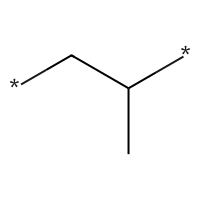

In [ ]:
smiles = "*CC(*)C"
mol = Chem.MolFromSmiles(smiles)
Draw.MolToImage(mol, kekulize=False, size=(200, 200))

## 4. Featurization, Model Training and Evaluation <a id="modeleval" />

With the required dataset loaded, we can proceed to train some models. Deepchem offers various models suitable for regression tasks in a molecular context. We have implemented a featurization mechanism, followed by model training, and recorded the training loss to validate the alignment of the data with the model.

The process of training each model is going be of following steps.
###### i. Set the featurizer
###### ii. Featurize the input values and combine the target to form a dataset / dataloader
###### iii. Configure the model
###### iv. Fit the model with the dataset / dataloader and record the training loss.

### i. Graph Convolution Neural Network (GCN)

Graph Convolutional Neural Networks (GCNs) are particularly effective in molecular modeling, as they can directly operate on the graph structure of molecules. In the context of our study, GCNs can be employed to capture the intricate relationships between atoms and bonds, offering a powerful method for predicting the crystallization tendency of polymers.


In [ ]:
# setting up the featurizer
molgraph_conv_featurizer = MolGraphConvFeaturizer()

# featurizing and preparing the dataset
X_molgraph_conv_train = molgraph_conv_featurizer.featurize(train_df["smiles"].values)

molgraph_conv_train=dc.data.NumpyDataset(X=X_molgraph_conv_train,y=train_df["Tg"].values)

X_molgraph_conv_test = molgraph_conv_featurizer.featurize(test_df["smiles"].values)


molgraph_conv_test=dc.data.NumpyDataset(X=X_molgraph_conv_test,y=test_df["Tg"].values)

X_molgraph_conv_valid = molgraph_conv_featurizer.featurize(valid_df["smiles"].values)


molgraph_conv_valid=dc.data.NumpyDataset(X=X_molgraph_conv_valid,y=valid_df["Tg"].values)

metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
losses_gcn, val_losses_gcn = [], []
# initializing the model class
GCN_MODEL = dc.models.GCNModel(
    mode="regression",
    n_tasks=1,
    batch_size=17,
    learning_rate=0.004,
)

In [ ]:
for n in range(49):
    l2_loss_GCN = GCN_MODEL.fit(molgraph_conv_train, nb_epoch=1)
    losses_gcn.append(l2_loss_GCN)
    val_loss_GCN = GCN_MODEL.evaluate(molgraph_conv_valid, [metric])
    val_losses_gcn.append(val_loss_GCN)

In [ ]:
prediction_GCN = GCN_MODEL.predict_on_batch(X_molgraph_conv_test)
for i in range(len(prediction_GCN)):
    print(prediction_GCN[i],test_df["Tg"].iloc[i])

[292.06876] 283.0
[312.33588] 298.0
[109.056946] 101.35
[136.24823] 142.0
[130.00374] 107.0
[148.59703] 141.0
[311.24063] 290.0
[340.35767] 358.0
[96.66342] 88.0
[190.6773] 186.0
[102.6586] 85.0
[160.80812] 155.0
[272.9422] 333.0
[197.76134] 193.0
[104.553375] 98.0
[325.21802] 315.0
[350.4274] 343.0
[172.55789] 162.8
[297.44116] 290.0
[287.50436] 269.6
[203.11807] 198.0
[172.55789] 162.2
[366.58505] 358.0
[402.41342] 393.0
[318.90216] 301.0
[120.12387] 125.0
[128.09033] 123.0
[292.06876] 284.0
[193.65091] 184.4
[173.49895] 181.4
[254.10893] 254.0
[170.88899] 126.3
[366.58505] 374.0
[394.92627] 371.0
[375.89484] 364.0
[287.50436] 269.6
[152.60747] 152.0
[301.9783] 284.0
[236.01154] 226.0
[111.829926] 119.4
[308.43042] 319.0
[179.58472] 178.0
[104.553375] 96.2
[444.4876] 433.0
[118.103004] 122.0
[314.4469] 297.0
[285.29544] 277.0
[176.61713] 158.0
[284.65186] 293.0
[402.41342] 393.0
[254.10893] 244.0
[258.34872] 258.0
[137.71909] 129.85
[281.72177] 286.0
[167.38391] 159.0
[420.70374] 360

### ii. Directed Message Passing Neural Network (D-MPNN)

Directed Message Passing Neural Networks (D-MPNNs) offer a sophisticated approach for molecular modeling by explicitly passing messages between atoms to capture the detailed structure of the molecule. In our study, D-MPNNs are used to predict the crystallization tendency of polymers. These networks operate by iteratively updating atom representations based on their neighbors, effectively capturing both local and global structural information. This method allows for precise modeling of the complex interactions within the molecular graph, leading to improved prediction accuracy.

In [ ]:
# setting up the featurizer
dmpnn_featurizer = dc.feat.DMPNNFeaturizer()

# featurizing and preparing the dataset
dmpnn_loader = dc.data.CSVLoader(tasks=['Tg'], feature_field='smiles', featurizer=dmpnn_featurizer)
dmpnn_dataset_train = dmpnn_loader.create_dataset("train.csv")
dmpnn_dataset_valid = dmpnn_loader.create_dataset("valid.csv")
dmpnn_dataset_test = dmpnn_loader.create_dataset("test.csv")

metric = dc.metrics.Metric(dc.metrics.mean_squared_error)

losses_dmpnn, val_losses_dmpnn = [], []

# initializing the model class
dmpnn_model = dc.models.torch_models.DMPNNModel(n_tasks=1,batch_size=17)

In [ ]:
for n in range(49):
    dmpnn_loss = dmpnn_model.fit(dmpnn_dataset_train, nb_epoch=1)
    losses_dmpnn.append(dmpnn_loss)
    dmpnn_val_loss = dmpnn_model.evaluate(dmpnn_dataset_valid, [metric])
    val_losses_dmpnn.append(dmpnn_val_loss)

In [ ]:
prediction_dmpnn=dmpnn_model.predict(dmpnn_dataset_test)
for i in range(len(prediction_dmpnn)):
    print(prediction_dmpnn[i], test_df["Tg"].iloc[i])

[282.21106] 283.0
[307.0001] 298.0
[132.4206] 101.35
[151.22546] 142.0
[126.82768] 107.0
[180.09923] 141.0
[285.08188] 290.0
[286.73212] 358.0
[93.22134] 88.0
[191.53247] 186.0
[104.87109] 85.0
[151.38695] 155.0
[287.4619] 333.0
[197.21552] 193.0
[106.33387] 98.0
[306.26462] 315.0
[433.03308] 343.0
[164.36763] 162.8
[307.47894] 290.0
[277.97238] 269.6
[187.64542] 198.0
[164.36763] 162.2
[350.7625] 358.0
[398.27164] 393.0
[340.60266] 301.0
[127.497246] 125.0
[124.34546] 123.0
[282.21106] 284.0
[187.02316] 184.4
[161.5356] 181.4
[248.53073] 254.0
[159.10904] 126.3
[350.7625] 374.0
[373.61813] 371.0
[344.42078] 364.0
[277.97238] 269.6
[151.50485] 152.0
[275.77505] 284.0
[225.02002] 226.0
[111.959724] 119.4
[265.53363] 319.0
[179.50343] 178.0
[106.33387] 96.2
[412.09738] 433.0
[121.514786] 122.0
[290.80316] 297.0
[278.95758] 277.0
[164.40424] 158.0
[322.48788] 293.0
[398.2716] 393.0
[248.53073] 244.0
[255.81349] 258.0
[133.92082] 129.85
[282.6959] 286.0
[152.69308] 159.0
[394.49417] 360.0


#### Evaluation Analysis

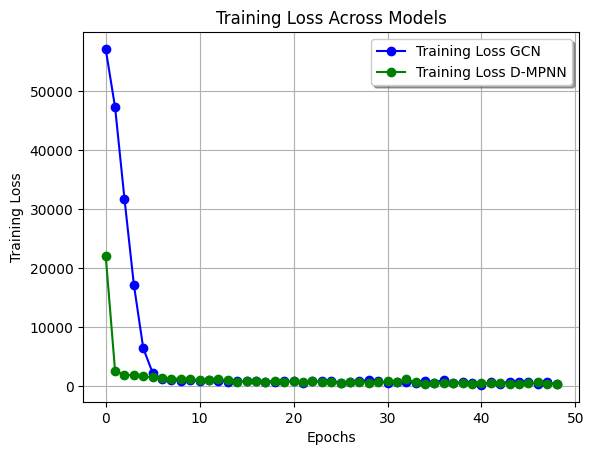

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

line2 = ax.plot(range(len(losses_gcn)), losses_gcn, label='Training Loss GCN', color='blue', marker='o')
line3 = ax.plot(range(len(losses_dmpnn)), losses_dmpnn, label='Training Loss D-MPNN', color='green', marker='o')

legend = ax.legend(loc='upper right', shadow=True)

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Across Models')
plt.grid(True)
plt.show()

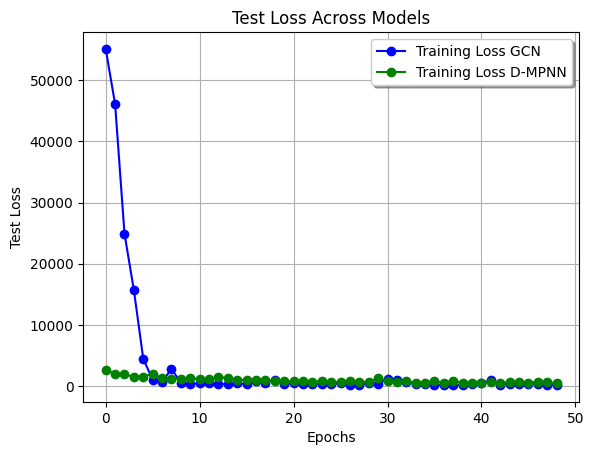

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

val_losses_gcn_values = [d['mean_squared_error'] for d in val_losses_gcn]
val_losses_dmpnn_values = [d['mean_squared_error'] for d in val_losses_dmpnn]

line2 = ax.plot(range(len(val_losses_gcn_values)), val_losses_gcn_values, label='Training Loss GCN', color='blue', marker='o')
line3 = ax.plot(range(len(val_losses_dmpnn_values)), val_losses_dmpnn_values, label='Training Loss D-MPNN', color='green', marker='o')

legend = ax.legend(loc='upper right', shadow=True)

plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Test Loss Across Models')
plt.grid(True)
plt.show()

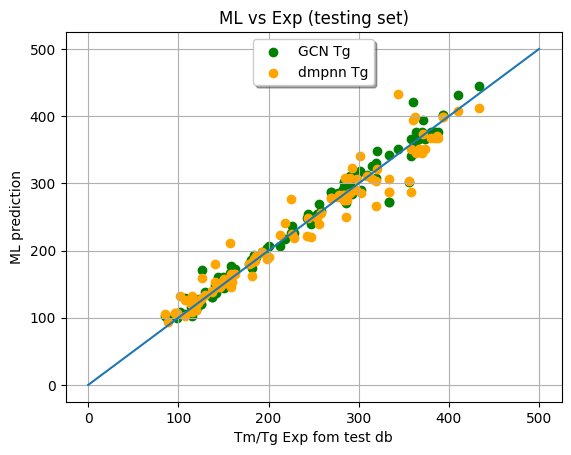


R2 SCORE
R2 score GCN Tg: 0.9722918992780949
R2 score DMPNN Tg: 0.9482144528937787

MSE SCORE
MSE GCN Tg: 256.3556289308161
MSE DMPNN Tg: 479.1204071034209

MAE SCORE
MAE GCN Tg: 10.943322841937725
MAE DMPNN Tg: 14.597248825660118

MAPE SCORE
MAPE GCN Tg: 0.0504490403840956
MAPE DMPNN Tg: 0.06561684666608976


In [ ]:
fig, ax = plt.subplots()

line1= ax.plot([0,500],[0,500])
# Convert potential masked arrays to 1-D numpy arrays
line3 = ax.scatter(np.array(test_df["Tg"]).flatten(), np.array(prediction_GCN).flatten(), label='GCN Tg', color='green', marker='o')
line5 = ax.scatter(np.array(test_df["Tg"]).flatten(), np.array(prediction_dmpnn).flatten(), label='dmpnn Tg', color='orange', marker='o')

legend = ax.legend(loc='upper center', shadow=True)


plt.xlabel('Tm/Tg Exp fom test db')
plt.ylabel('ML prediction')
plt.title('ML vs Exp (testing set)')
plt.grid(True)
plt.show()

#R2 score, PEARSON
r2_GCN_Tg=r2_score(np.array(test_df["Tg"]).flatten(), np.array(prediction_GCN).flatten())
r2_dmpnn_Tg=r2_score(np.array(test_df["Tg"]).flatten(), np.array(prediction_dmpnn).flatten())

print("\nR2 SCORE")
print("R2 score GCN Tg:",  r2_GCN_Tg)
print("R2 score DMPNN Tg:",  r2_dmpnn_Tg)

#MSE score
mse_GCN_Tg=mean_squared_error(np.array(test_df["Tg"]).flatten(), np.array(prediction_GCN).flatten())
mse_dmpnn_Tg=mean_squared_error(np.array(test_df["Tg"]).flatten(), np.array(prediction_dmpnn).flatten())
print("\nMSE SCORE")
print("MSE GCN Tg:",  mse_GCN_Tg)
print("MSE DMPNN Tg:",  mse_dmpnn_Tg)

#MAE score
mae_GCN_Tg=mean_absolute_error(np.array(test_df["Tg"]).flatten(), np.array(prediction_GCN).flatten())
mae_dmpnn_Tg=mean_absolute_error(np.array(test_df["Tg"]).flatten(), np.array(prediction_dmpnn).flatten())
print("\nMAE SCORE")
print("MAE GCN Tg:",  mae_GCN_Tg)
print("MAE DMPNN Tg:",  mae_dmpnn_Tg)

#MAPE
mape_GCN_Tg=mean_absolute_percentage_error(np.array(test_df["Tg"]).flatten(), np.array(prediction_GCN).flatten())
mape_dmpnn_Tg=mean_absolute_percentage_error(np.array(test_df["Tg"]).flatten(), np.array(prediction_dmpnn).flatten())

print("\nMAPE SCORE")
print("MAPE GCN Tg:",  mape_GCN_Tg)
print("MAPE DMPNN Tg:",  mape_dmpnn_Tg)